In [1]:
from IPython.display import HTML

HTML(f"""
<div style="background-color: #ffcc00; padding: 25px; border-radius: 15px; color: #000; display: flex; align-items: center; justify-content: space-between; width: 100%;">

  <div style="flex: 1;">
    <h1 style="text-align: center; font-size: 28px; font-weight: bold; margin-bottom: 10px;">🎟️ Исследовательский анализ пользовательского поведения на сервисе «Яндекс Афиша»</h1>
    <h3 style="text-align: center; font-size: 18px;">📅 Период анализа: 1 июня — 31 октября 2024 года</h3>
  </div>

  <div style="flex: 0 0 160px; margin-left: 30px;">
    <img src="https://i.postimg.cc/8Ck6VpSw/artem.jpg" alt="Автор проекта" style="width: 160px; border-radius: 12px;">
  </div>

</div>
""")


---

## 👤 Автор проекта

**Артем Байков — аналитик и маркетолог**

Проект выполнен в рамках дипломной работы по аналитике данных.


---

## 🎯 Цель проекта

Проанализировать поведение пользователей сервиса «Яндекс Афиша» летом и осенью 2024 года,  
а также выявить изменения в популярности мероприятий, активности пользователей и провести проверку продуктовых гипотез.

---

## 📌 План действий

1. **Оформление и структура проекта**
2. **Загрузка и первичный обзор данных**
3. **Предобработка данных и обогащение признаками**
4. **Исследовательский анализ данных**
   - Распределение заказов по категориям
   - Сезонные изменения спроса
   - Активность пользователей в осенний период
   - Популярные события, регионы и партнёры
5. **Проверка гипотез**
   - Сравнение поведения пользователей мобильных и стационарных устройств
6. **Общий вывод и рекомендации**


In [3]:
# Работа с таблицами и данными
import pandas as pd
import numpy as np
import os

# Работа с датами и временем
import datetime as dt

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Проверка гипотез
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import normaltest

---

## 🔍 Шаг 1. Загрузка данных и знакомство с ними

На этом этапе мы:
- загружаем основные датасеты проекта;
- проверяем структуру данных и типы столбцов;
- оцениваем объём данных;
- делаем первые наблюдения и формулируем, что потребуется на этапе предобработки.


In [5]:
# Возможные пути
local_path = './datasets/'
server_path = 'https://code.s3.yandex.net/datasets/'

# Названия файлов
files = {
    "orders": "final_tickets_orders_df.csv",
    "events": "final_tickets_events_df.csv",
    "tenge": "final_tickets_tenge_df.csv"
}

# Функция для безопасной загрузки
def safe_read_csv(filename, parse_dates=None, index_col=None):
    local_file = os.path.join(local_path, filename)
    remote_file = os.path.join(server_path, filename)
    try:
        if os.path.exists(local_file):
            return pd.read_csv(local_file, parse_dates=parse_dates, index_col=index_col)
        else:
            return pd.read_csv(remote_file, parse_dates=parse_dates, index_col=index_col)
    except Exception as e:
        print(f"Ошибка при загрузке {filename}: {e}")
        return None

# Загрузка датасетов
orders_df = safe_read_csv(files["orders"])
events_df = safe_read_csv(files["events"])
tenge_df = safe_read_csv(files["tenge"])

In [6]:
# Просмотр размеров таблиц
print("📦 Размер orders_df:", orders_df.shape)
print("📦 Размер events_df:", events_df.shape)
print("📦 Размер tenge_df:", tenge_df.shape)

📦 Размер orders_df: (290849, 14)
📦 Размер events_df: (22427, 11)
📦 Размер tenge_df: (357, 4)


In [7]:
# Быстрый просмотр первых строк
display(orders_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [8]:
display(events_df.head())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [9]:
display(tenge_df.head())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [10]:
# Информация о типах данных и пропусках
print("\n📑 Структура orders_df:")
orders_df.info()

print("\n📑 Структура events_df:")
events_df.info()

print("\n📑 Структура tenge_df:")
tenge_df.info()



📑 Структура orders_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3

---

### 🗂️ Описание данных

В проекте используются три датасета:

#### 📄 `final_tickets_orders_df.csv`
Содержит информацию о заказах билетов с устройств `mobile` и `desktop`.  
**Размер:** 290 849 строк, 14 столбцов.

Ключевые поля:
- `order_id` — идентификатор заказа  
- `user_id` — пользователь  
- `created_dt_msk` / `created_ts_msk` — дата и время заказа  
- `event_id` — мероприятие  
- `currency_code` — валюта (`rub` / `kzt`)  
- `device_type_canonical` — тип устройства  
- `revenue` — выручка с заказа  
- `tickets_count` — количество билетов  
- `days_since_prev` — дни с момента предыдущего заказа (если был)

---

#### 📄 `final_tickets_events_df.csv`
Информация о событиях, исключая фильмы.  
**Размер:** 22 427 строк, 11 столбцов.

Ключевые поля:
- `event_id` — идентификатор мероприятия  
- `event_name` — код названия мероприятия  
- `event_type_main` — тип события (театр, концерт и т. д.)  
- `region_name`, `city_name` — регион и город  
- `venue_name` — площадка проведения

---

#### 📄 `final_tickets_tenge_df.csv`
Исторический курс KZT к RUB за 2024 год (для пересчёта выручки).  
**Размер:** 357 строк, 4 столбца.

Ключевые поля:
- `data` — дата  
- `curs` — курс тенге за 100 единиц к рублю

---

#### 📝 Промежуточный вывод
Все датасеты успешно загружены. Структура и размеры соответствуют ожиданиям.  
В данных уже учтена фильтрация по типам устройств.  
Поле `days_since_prev` содержит пропуски, что ожидаемо.  
Далее будет проведена предобработка и расчёт новых метрик.


---

## 🛠️ Шаг 2. Предобработка данных и подготовка к исследованию

На этом этапе мы:
- проверим данные на наличие пропусков и дубликатов;
- приведём типы данных к корректным;
- изучим и нормализуем категориальные признаки;
- проверим распределение количественных признаков и устраним выбросы;
- добавим новые столбцы: приведённую выручку в рублях, стоимость одного билета, сезонность и месяц.

Цель — подготовить «чистый» датафрейм для дальнейшего анализа и визуализации.


In [13]:
# Копируем исходные данные, чтобы не портить оригинал
df = orders_df.copy()

# Преобразуем даты
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'])

In [14]:
# Проверка на пропуски
missing = df.isnull().sum()
missing_percent = (missing / len(df)).round(3) * 100
missing_table = pd.DataFrame({'Пропуски': missing, 'Доля (%)': missing_percent})
display(missing_table[missing_table['Пропуски'] > 0].sort_values('Пропуски', ascending=False))

# Автоматический анализ всех категориальных признаков
cat_cols_auto = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols_auto:
    print(f"\n📌 {col}: {df[col].nunique()} уникальных значений")
    print(df[col].value_counts(dropna=False).head(10))

,Пропуски,Доля (%)
days_since_prev,21940,7.5



📌 user_id: 21940 уникальных значений
user_id
0beb8fc0c0a9ce1    10258
18e9aead0a393e7     4368
8187dac4be757a0     4061
3ee7dc2e115847f     3833
7eb4fc207ecc10f     3751
1c2a2133e1df1b4     3539
4ec8f6429431987     3413
ad2dc32364ed948     3279
b54dd0cd81121fc     3164
cdbc02c6ad8087a     3072
Name: count, dtype: int64

📌 cinema_circuit: 6 уникальных значений
cinema_circuit
нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: count, dtype: int64

📌 currency_code: 2 уникальных значений
currency_code
rub    285780
kzt      5069
Name: count, dtype: int64

📌 device_type_canonical: 2 уникальных значений
device_type_canonical
mobile     232679
desktop     58170
Name: count, dtype: int64

📌 service_name: 36 уникальных значений
service_name
Билеты без проблем    63709
Лови билет!           41126
Билеты в руки         40364
Мой билет             34843
Облачко               26642
Лучшие билеты         17795
Весь в би

---

### 🔍 Проверка и нормализация категориальных признаков

- Пропуски найдены только в `days_since_prev` — это допустимо, так как означает первый заказ пользователя.
- В `currency_code`, `device_type_canonical` и `age_limit` значения корректны, дубликатов не обнаружено.
- `cinema_circuit` почти полностью заполнен значением `'нет'` (более 99%) — признак можно не использовать в анализе.
- В `service_name` — 36 уникальных значений, топ-10 покрывают большую часть данных.


In [16]:
# Приводим к нижнему регистру потенциально "ручные" поля (на всякий случай)
df['device_type_canonical'] = df['device_type_canonical'].str.lower()
df['currency_code'] = df['currency_code'].str.lower()
df['cinema_circuit'] = df['cinema_circuit'].str.strip().str.lower()
df['service_name'] = df['service_name'].str.strip()

In [17]:
# Проверка на полные дубликаты строк
print(f"📌 Полных дубликатов: {df.duplicated().sum()}")

📌 Полных дубликатов: 0


In [18]:
# Проверка на неявные дубликаты по всем признакам, кроме order_id
dedup_columns = [col for col in df.columns if col != 'order_id']
duplicated_count = df.duplicated(subset=dedup_columns).sum()
print(f"📌 Неявных дубликатов по всем признакам, кроме order_id: {duplicated_count}")

📌 Неявных дубликатов по всем признакам, кроме order_id: 30


In [19]:
# Удаляем неявные дубликаты по ключевым полям
df = df.drop_duplicates(subset=dedup_columns, keep='first').reset_index(drop=True)

print(f"✅ Размер после удаления дубликатов: {df.shape}")

✅ Размер после удаления дубликатов: (290819, 14)


---

### 📊 Анализ количественных признаков и выбросов

На этом этапе:
- изучим распределение по `revenue` и `tickets_count`;
- проверим наличие аномально высоких значений (выбросов);
- применим фильтрацию по 99-му процентилю для `revenue`, отдельно для RUB и KZT;
- визуализируем распределения до и после фильтрации.


In [21]:
# Отдельные выборки по валютам
rub_df = df[df['currency_code'] == 'rub'].copy()
kzt_df = df[df['currency_code'] == 'kzt'].copy()

📈 RUB – статистика выручки:
count    285750.000000
mean        547.590617
std         871.556472
min         -90.760000
25%         113.862500
50%         346.180000
75%         791.700000
90%        1276.150000
99%        2569.600200
max       81174.540000
Name: revenue, dtype: float64

📈 KZT – статистика выручки:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
90%      13212.930000
99%      17617.240000
max      26425.860000
Name: revenue, dtype: float64


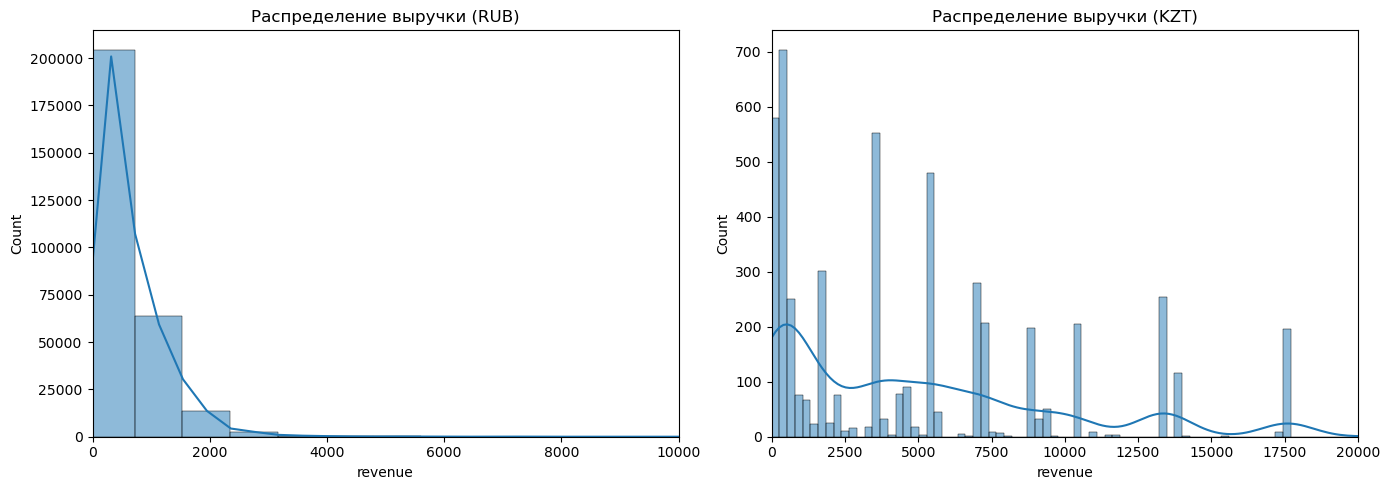

In [22]:
# Посмотрим на основные метрики по revenue
print("📈 RUB – статистика выручки:")
print(rub_df['revenue'].describe(percentiles=[.25, .5, .75, .90, .99]))

print("\n📈 KZT – статистика выручки:")
print(kzt_df['revenue'].describe(percentiles=[.25, .5, .75, .90, .99]))

# Гистограммы
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(rub_df['revenue'], bins=100, kde=True)
plt.title('Распределение выручки (RUB)')
plt.xlim(0, 10000)

plt.subplot(1, 2, 2)
sns.histplot(kzt_df['revenue'], bins=100, kde=True)
plt.title('Распределение выручки (KZT)')
plt.xlim(0, 20000)

plt.tight_layout()
plt.show()

---

#### 🧾 Промежуточный вывод по выручке

- Распределение `revenue` в обеих валютах **асимметрично и смещено вправо**, что указывает на наличие значительных выбросов.
- В **рублях**:
  - Среднее значение: **548 ₽**, медиана: **346 ₽**;
  - 99% заказов — до **2 570 ₽**.
- В **тенге**:
  - Среднее значение: **4 995 ₸**, медиана: **3 699 ₸**;
  - 99% заказов — до **17 617 ₸**.
- Для повышения качества анализа и визуализации принята мера: **ограничение данных 99-м процентилем** в каждой валюте.


In [24]:
# Расчёт 99-го процентиля
rub_q99 = rub_df['revenue'].quantile(0.99)
kzt_q99 = kzt_df['revenue'].quantile(0.99)

# Фильтрация
rub_filtered = rub_df[rub_df['revenue'] <= rub_q99]
kzt_filtered = kzt_df[kzt_df['revenue'] <= kzt_q99]

# Объединяем обратно
df_filtered = pd.concat([rub_filtered, kzt_filtered], ignore_index=True)

print(f"✅ Итоговый размер после фильтрации выбросов: {df_filtered.shape}")

✅ Итоговый размер после фильтрации выбросов: (287932, 14)


📈 Статистика количества билетов в заказе:
count    290819.000000
mean          2.754256
std           1.170461
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
90%           4.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64


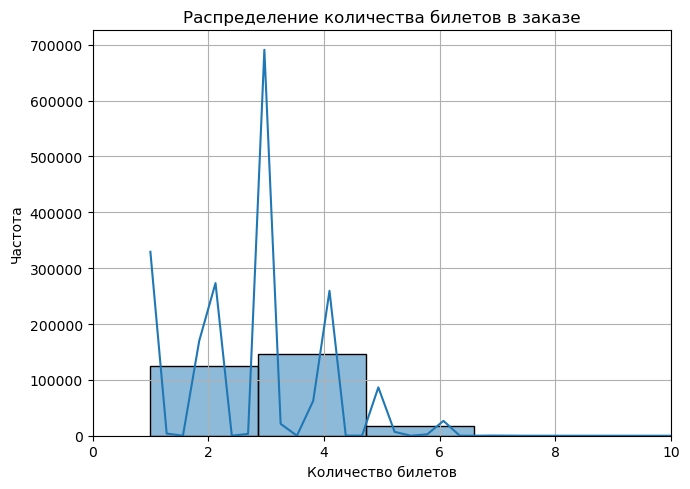

✅ Итоговый размер после фильтрации выбросов: (287752, 14)


In [25]:
# Посмотрим на основные метрики по количеству билетов
print("📈 Статистика количества билетов в заказе:")
print(df['tickets_count'].describe(percentiles=[.25, .5, .75, .90, .99]))

# Гистограмма
plt.figure(figsize=(7, 5))
sns.histplot(df['tickets_count'], bins=30, kde=True)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.xlim(0, 10)  # ограничим ось X для наглядности
plt.grid(True)
plt.tight_layout()
plt.show()

# Порог по выручке
rub_q99 = rub_df['revenue'].quantile(0.99)
kzt_q99 = kzt_df['revenue'].quantile(0.99)

# Порог по количеству билетов
tickets_q99 = df['tickets_count'].quantile(0.99)

# Фильтрация
rub_filtered = rub_df[(rub_df['revenue'] <= rub_q99) & (rub_df['tickets_count'] <= tickets_q99)]
kzt_filtered = kzt_df[(kzt_df['revenue'] <= kzt_q99) & (kzt_df['tickets_count'] <= tickets_q99)]

# Объединение
df_filtered = pd.concat([rub_filtered, kzt_filtered], ignore_index=True)

print(f"✅ Итоговый размер после фильтрации выбросов: {df_filtered.shape}")


#### 🧾 Промежуточный вывод по количеству билетов

- Распределение `tickets_count` сильно смещено влево — большинство пользователей покупают **1–3 билета**, максимум — 57.
- 99% заказов включают до **6 билетов**, что говорит о наличии **редких групповых покупок** (например, на школьные мероприятия).
- Для адекватного анализа **целесообразно ограничить данные по 99-му процентилю**.

✅ После фильтрации выбросов по `tickets_count` получено **287 752** строк.


---

### 🧮 Добавление новых признаков

Добавим следующие столбцы:
- `revenue_rub` — выручка, приведённая к рублям (по курсу для заказов в тенге);
- `one_ticket_revenue_rub` — средняя стоимость одного билета (в рублях);
- `month` — месяц оформления заказа;
- `season` — сезон (лето / осень).


In [28]:
# Копируем очищенный датафрейм
df_ready = df_filtered.copy()

# Приводим дату в тенге-фрейме к datetime
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

# Добавим дату без времени в основной датафрейм
df_ready['created_date'] = df_ready['created_dt_msk'].dt.date
df_ready['created_date'] = pd.to_datetime(df_ready['created_date'])

# Мержим курс по дате
df_ready = df_ready.merge(
    tenge_df[['data', 'curs']],
    left_on='created_date',
    right_on='data',
    how='left'
)

# Рассчитаем выручку в рублях
df_ready['revenue_rub'] = np.where(
    df_ready['currency_code'] == 'kzt',
    df_ready['revenue'] * df_ready['curs'] / 100,
    df_ready['revenue']
)

# Стоимость одного билета
df_ready['one_ticket_revenue_rub'] = df_ready['revenue_rub'] / df_ready['tickets_count']

# Месяц и сезон
df_ready['month'] = df_ready['created_dt_msk'].dt.month

def get_season(month):
    if month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'
    elif month in [12, 1, 2]:
        return 'зима'
    else:
        return 'весна'

df_ready['season'] = df_ready['month'].apply(get_season)

# Проверим
display(df_ready[['currency_code', 'revenue', 'revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']].head())


,currency_code,revenue,revenue_rub,one_ticket_revenue_rub,month,season
0,rub,1521.94,1521.94,380.4850,8,лето
1,rub,289.45,289.45,144.7250,7,лето
2,rub,1258.57,1258.57,314.6425,10,осень
3,rub,8.49,8.49,4.2450,7,лето
4,rub,1390.41,1390.41,463.4700,10,осень


### 🧾 Предварительные выводы по шагу 2

🔹 Данные успешно загружены и проверены на соответствие описанию. После обработки и удаления неявных дубликатов осталось **287 752 строк**.

🔹 Обнаружено:
- **0** полных дубликатов;
- **30** неявных дубликатов по всем признакам (кроме `order_id`) — удалены.

🔹 Проведён анализ распределения числовых признаков:
- **Выручка**:
  - для RUB: 99% заказов — до **2 570 ₽**;
  - для KZT: 99% заказов — до **17 617 ₸**;
- **Количество билетов**:
  - 99% заказов содержат до **6 билетов**;
→ Для улучшения качества анализа выбросы были отфильтрованы.

🔹 Добавлены новые признаки:
- `revenue_rub` — приведённая выручка в рублях;
- `one_ticket_revenue_rub` — стоимость одного билета;
- `month` — месяц заказа;
- `season` — сезон (лето, осень).

✅ Данные очищены, готовы к исследовательскому анализу и визуализации.


## 📊 Шаг 3. Исследовательский анализ данных

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

В этом подэтапе:
- изучим динамику заказов по месяцам;
- сравним лето и осень по категориям:
  - тип мероприятия (`event_type_main`);
  - тип устройства (`device_type_canonical`);
  - возрастные ограничения (`age_limit`);
- визуализируем доли заказов по категориям;
- сравним среднюю стоимость билета летом и осенью.

Цель — выявить ключевые изменения в пользовательском поведении и интересах по сезонам.


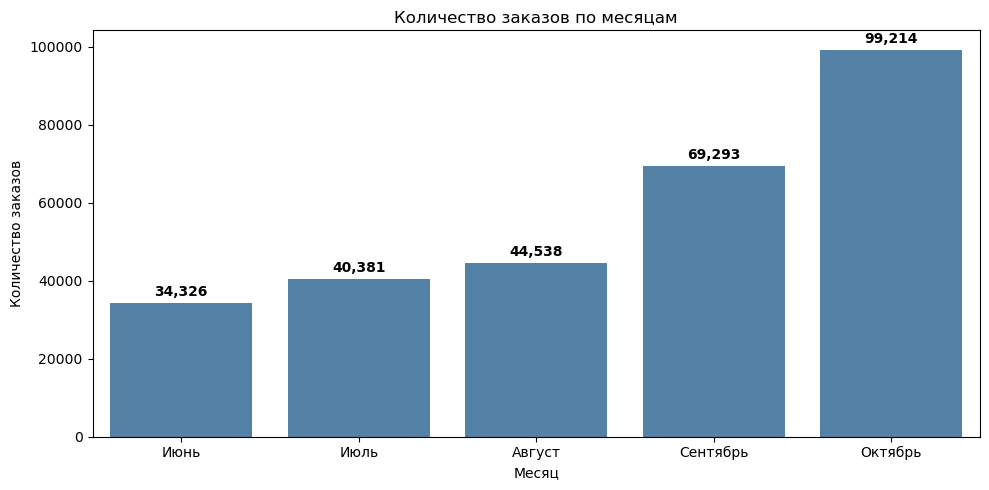

In [31]:
monthly_orders = (
    df_ready
    .groupby('month')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'orders_count'})
)

# Добавим красивое название месяца
month_names = {
    6: 'Июнь', 7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь'
}
monthly_orders['month_name'] = monthly_orders['month'].map(month_names)

# Отрисовка
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=monthly_orders, x='month_name', y='orders_count', color='steelblue')

# Подписи над столбцами
for index, row in monthly_orders.iterrows():
    ax.text(
        index,
        row['orders_count'] + 1000,
        f"{row['orders_count']:,}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()



## 📊 Предварительный вывод №1: Рост количества заказов по месяцам

Наблюдается **устойчивый рост пользовательской активности** от июня к октябрю:

- В **июне** оформлено **34 326 заказа**;
- В **октябре** — уже **99 214 заказов**;
- Общее увеличение составляет почти **в 3 раза**.

📌 Это подтверждает наличие **ярко выраженной сезонности спроса** — вероятно, рост связан с началом культурного сезона осенью и подготовкой к мероприятиям.

---

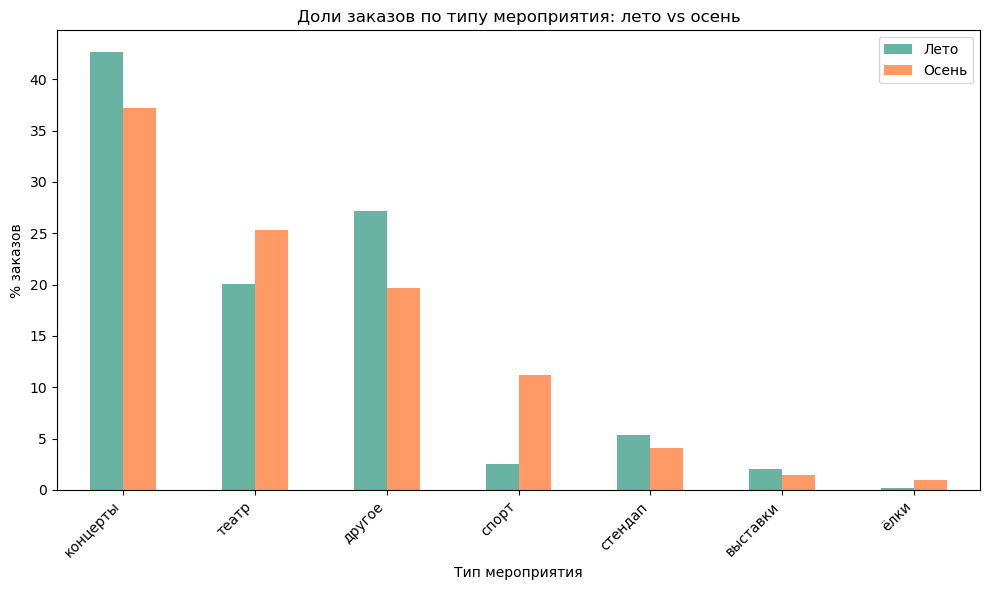

In [33]:
# Объединяем по event_id
df_ready = df_ready.merge(events_df[['event_id', 'event_type_main']], on='event_id', how='left')

# Отбор лета и осени
summer_df = df_ready[df_ready['season'] == 'лето']
autumn_df = df_ready[df_ready['season'] == 'осень']

# Группировка и нормализация
summer_event_share = (
    summer_df['event_type_main'].value_counts(normalize=True) * 100
).rename('summer_share')

autumn_event_share = (
    autumn_df['event_type_main'].value_counts(normalize=True) * 100
).rename('autumn_share')

# Объединение
event_share_df = pd.concat([summer_event_share, autumn_event_share], axis=1).fillna(0).sort_values('autumn_share', ascending=False)

# Построение графика
event_share_df.plot(kind='bar', figsize=(10, 6), color=['#69b3a2', '#ff9966'])
plt.title('Доли заказов по типу мероприятия: лето vs осень')
plt.ylabel('% заказов')
plt.xlabel('Тип мероприятия')
plt.xticks(rotation=45, ha='right')
plt.legend(['Лето', 'Осень'])
plt.tight_layout()
plt.show()

## 🎭 Предварительный вывод №2: Изменения в интересах пользователей (лето vs осень)

📌 При сравнении долей заказов по типам мероприятий между летом и осенью выявлены следующие тренды:

- **Театры** и **спортивные события** стали **более популярны осенью**.
- **Концерты** остались самой востребованной категорией, но их доля **немного снизилась**.
- В категории **«ёлки»** появились первые заказы — это сигнал начала спроса на новогодние мероприятия.

Таким образом, интересы пользователей осенью смещаются в сторону **более камерных и сезонных событий**.

---

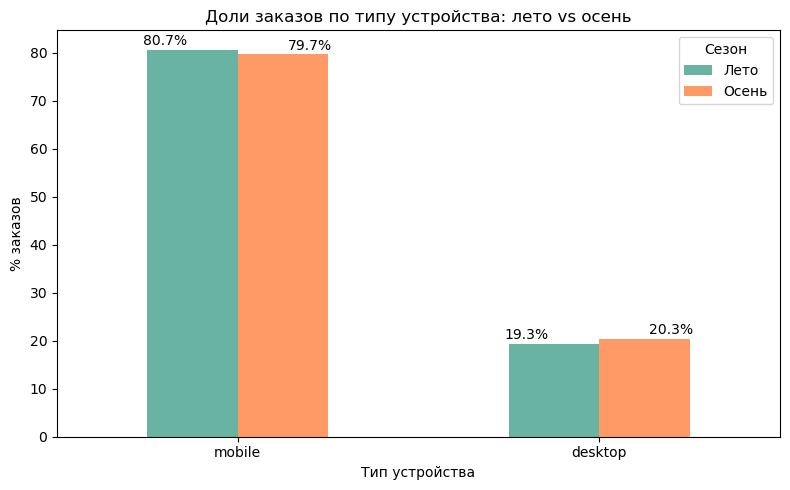

In [35]:
# Группировка и расчёт долей заказов по устройствам
summer_device_share = (
    df_ready[df_ready['season'] == 'лето']['device_type_canonical']
    .value_counts(normalize=True) * 100
).rename('Лето')

autumn_device_share = (
    df_ready[df_ready['season'] == 'осень']['device_type_canonical']
    .value_counts(normalize=True) * 100
).rename('Осень')

# Объединение
device_share_df = pd.concat([summer_device_share, autumn_device_share], axis=1).fillna(0)

# Построение графика
ax = device_share_df.plot(kind='bar', figsize=(8, 5), color=['#69b3a2', '#ff9966'])

# Добавим подписи над столбцами
for i, (index, row) in enumerate(device_share_df.iterrows()):
    ax.text(i - 0.2, row['Лето'] + 1, f"{row['Лето']:.1f}%", ha='center', fontsize=10, color='#000000')
    ax.text(i + 0.2, row['Осень'] + 1, f"{row['Осень']:.1f}%", ha='center', fontsize=10, color='#000000')

plt.title('Доли заказов по типу устройства: лето vs осень')
plt.ylabel('% заказов')
plt.xlabel('Тип устройства')
plt.xticks(rotation=0)
plt.legend(title='Сезон')
plt.tight_layout()
plt.show()

## 📱 Предварительный вывод: распределение заказов по устройствам

- Основной канал оформления заказов — мобильные устройства. Независимо от сезона, доля заказов с мобильных устройств составляет **около 80%**.
- Доля пользователей со стационарных устройств остаётся стабильной — **примерно 19.5%**.
- Таким образом, поведение пользователей по типу устройства не изменилось с наступлением осени — спрос сместился не по каналам, а, вероятно, по типам мероприятий.
---

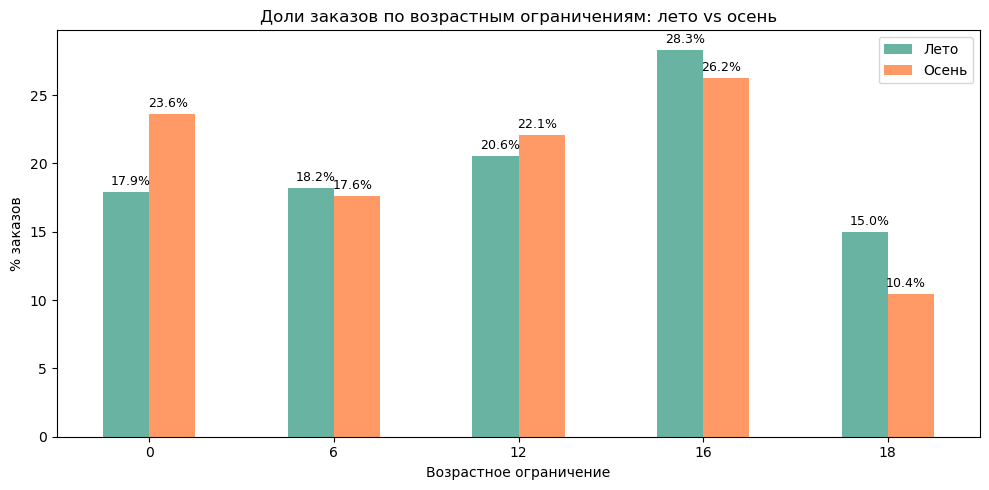

In [37]:
# Группировка по возрастным ограничениям для лета и осени
summer_age_share = (
    summer_df['age_limit'].value_counts(normalize=True) * 100
).rename('summer_share')

autumn_age_share = (
    autumn_df['age_limit'].value_counts(normalize=True) * 100
).rename('autumn_share')

# Объединение
age_share_df = pd.concat([summer_age_share, autumn_age_share], axis=1).fillna(0).sort_values('autumn_share', ascending=False)

# Сортировка по возрастному ограничению
age_order = [0, 6, 12, 16, 18]
age_share_df = age_share_df.reindex(age_order)

# Визуализация с сортировкой
ax = age_share_df.plot(kind='bar', figsize=(10, 5), color=['#69b3a2', '#ff9966'])
plt.title('Доли заказов по возрастным ограничениям: лето vs осень')
plt.ylabel('% заказов')
plt.xlabel('Возрастное ограничение')
plt.xticks(rotation=0)
plt.legend(['Лето', 'Осень'])

# Подписи над столбцами
for i, col in enumerate(age_share_df.columns):
    for j, value in enumerate(age_share_df[col]):
        ax.text(j + (i - 0.5) * 0.2, value + 0.5, f'{value:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


### 📌 Предварительный вывод: Возрастные ограничения

Анализ заказов по возрастным ограничениям выявил три наиболее популярные категории: **16+**, **12+** и **0+**.

- Осенью заметен **рост доли заказов на мероприятия 0+ и 12+**, что говорит о повышенном интересе к **семейному и детскому контенту** — вероятно, в связи с началом учебного года.
- Доля мероприятий **18+** снижается осенью, что может указывать на спад интереса к взрослому досугу в этот период.

📌 Спрос смещается в сторону **более универсальных и семейных форматов**.


---

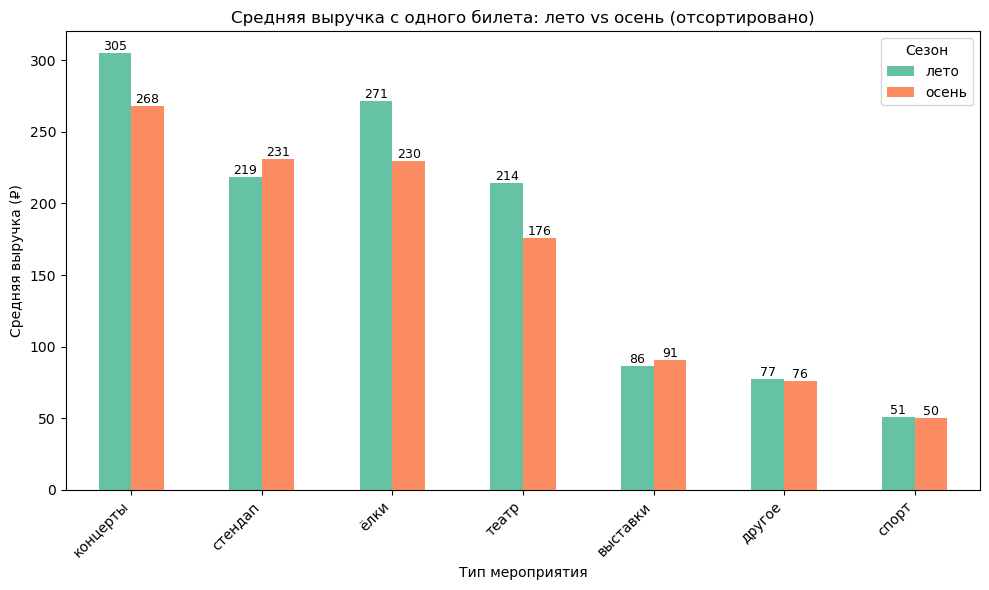

season                 лето       осень  change_%
event_type_main                                  
выставки          86.416198   90.603610       4.8
другое            77.391815   76.059694      -1.7
концерты         304.731672  268.106924     -12.0
спорт             50.744650   49.986591      -1.5
стендап          218.518107  231.124973       5.8
театр            214.166972  175.984021     -17.8
ёлки             271.436176  229.564210     -15.4


In [39]:
# Расчёт средней выручки с билета в рублях по типу мероприятия и сезону
ticket_rev_by_season = (
    df_ready
    .groupby(['event_type_main', 'season'])['one_ticket_revenue_rub']
    .mean()
    .unstack()
)

# Добавим столбец с относительным изменением (осень к лету)
ticket_rev_by_season['change_%'] = (
    (ticket_rev_by_season['осень'] - ticket_rev_by_season['лето']) / ticket_rev_by_season['лето'] * 100
).round(1)

# Сортировка по средней выручке осенью
ticket_rev_sorted = ticket_rev_by_season[['лето', 'осень']].sort_values(by='осень', ascending=False)

# Построение графика
ax = ticket_rev_sorted.plot(kind='bar', figsize=(10, 6), color=['#66c2a5', '#fc8d62'])
plt.title('Средняя выручка с одного билета: лето vs осень (отсортировано)')
plt.ylabel('Средняя выручка (₽)')
plt.xlabel('Тип мероприятия')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезон')

# Подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


# Таблица с процентным изменением (если нужно для подписи)
print(ticket_rev_by_season[['лето', 'осень', 'change_%']])


### 📊 Предварительный вывод: Средняя выручка с одного билета летом и осенью

Сравнение средней выручки по типам мероприятий показало следующее:

- **Концерты**, **ёлки** и **театр** остаются самыми доходными категориями, но осенью они теряют в выручке: театр — **-17,8%**, ёлки — **-15,4%**, концерты — **-12%**.
- На фоне падения других категорий **стендап** и **выставки**, напротив, показали рост: **+5,8%** и **+4,8%** соответственно.
- Категории **спорт** и **другое** изменились незначительно (в пределах ±2%).

📌 Это может свидетельствовать о сдвиге интересов аудитории и адаптации цен в зависимости от сезона.


---

## 🧾 Общий вывод по шагу 3.1

- С наступлением осени наблюдается **значительный рост количества заказов**: с **34 тыс. в июне** до **99 тыс. в октябре**. Это подтверждает наличие выраженной **сезонности спроса**.

- **Структура заказов по типам мероприятий** изменилась: доля **театров** выросла, а доля **концертов** и **ёлок** снизилась. Это может отражать смену форматов культурного досуга в осенний период.

- По **типам устройств** существенных сдвигов не выявлено — доля заказов с мобильных устройств остаётся стабильно высокой (**около 80%**), что подтверждает доминирование мобильного канала продаж.

- В разрезе **возрастных ограничений** осенью наблюдается **снижение доли мероприятий 18+** (с **15% до 10,4%**) и **рост доли заказов на категории 0+ и 12+**, что указывает на смещение интереса аудитории к более семейным форматам.

- **Средняя выручка с одного билета** снизилась у большинства категорий мероприятий: особенно у **театров (–17,8%)**, **ёлок (–15,4%)** и **концертов (–12%)**. Рост отмечен только у **стендапа (+5,8%)** и **выставок (+4,8%)**.

📌 Эти тенденции указывают на перераспределение интересов аудитории и возможную адаптацию ценовой политики в зависимости от сезона.


---


## 3.2. Осенняя активность пользователей

В этом подэтапе:

- проанализируем активность пользователей в сентябре и октябре:
  - общее число заказов;
  - ежедневное количество уникальных пользователей (DAU);
  - среднее число заказов на одного пользователя;
  - средняя стоимость одного билета;
- визуализируем полученные метрики;
- исследуем недельную цикличность активности:
  - по дням недели;
  - сравнение будней и выходных.

**Цель** — определить особенности пользовательского поведения в осенний период и выявить закономерности в активности по дням.


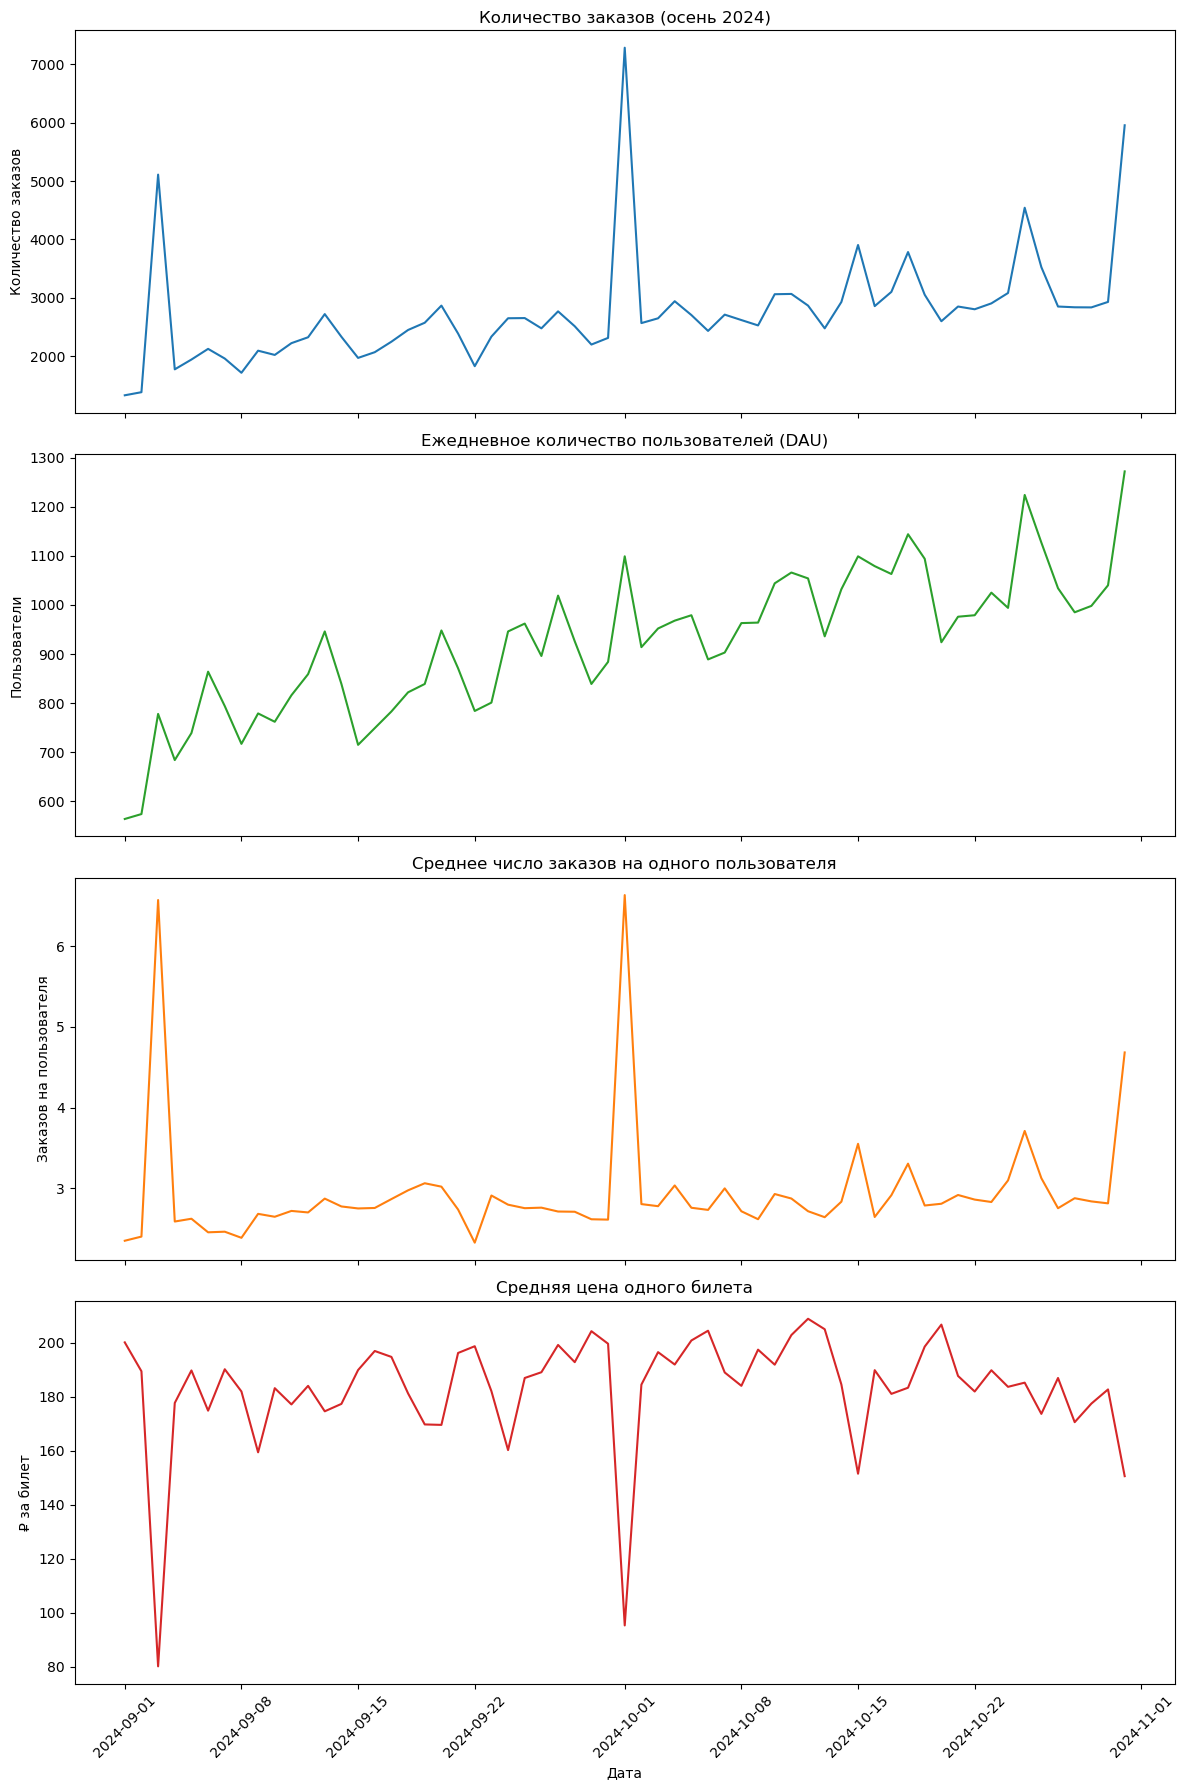

In [43]:
# Фильтрация осенних данных
df_autumn = df_ready[df_ready['season'] == 'осень'].copy()

# Преобразуем дату в формат datetime
df_autumn['created_dt_msk'] = pd.to_datetime(df_autumn['created_dt_msk'])

# Группировка по дням
daily_stats = df_autumn.groupby('created_dt_msk').agg({
    'order_id': 'count',
    'user_id': pd.Series.nunique,
    'tickets_count': 'sum',
    'one_ticket_revenue_rub': 'mean'
}).rename(columns={
    'order_id': 'orders_count',
    'user_id': 'dau',
    'one_ticket_revenue_rub': 'avg_ticket_price'
})

# Среднее число заказов на пользователя
daily_stats['orders_per_user'] = daily_stats['orders_count'] / daily_stats['dau']

# Отрисовка на 4 отдельных графиках
fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

# 1. Количество заказов
axes[0].plot(daily_stats.index, daily_stats['orders_count'], color='tab:blue')
axes[0].set_title('Количество заказов (осень 2024)')
axes[0].set_ylabel('Количество заказов')

# 2. Уникальные пользователи (DAU)
axes[1].plot(daily_stats.index, daily_stats['dau'], color='tab:green')
axes[1].set_title('Ежедневное количество пользователей (DAU)')
axes[1].set_ylabel('Пользователи')

# 3. Заказов на пользователя
axes[2].plot(daily_stats.index, daily_stats['orders_per_user'], color='tab:orange')
axes[2].set_title('Среднее число заказов на одного пользователя')
axes[2].set_ylabel('Заказов на пользователя')

# 4. Средняя цена билета
axes[3].plot(daily_stats.index, daily_stats['avg_ticket_price'], color='tab:red')
axes[3].set_title('Средняя цена одного билета')
axes[3].set_ylabel('₽ за билет')

# Общая настройка оси X
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 📊 Предварительный вывод: ежедневная динамика метрик (осень 2024)

- **Число заказов** демонстрирует выраженную положительную динамику — с начала сентября до конца октября наблюдается рост активности с периодическими пиками по выходным и особенно в конце месяца.
- **DAU (уникальные пользователи в день)** также растёт, но более плавно. Это может говорить о постепенном расширении аудитории или возвращении пользователей.
- **Среднее число заказов на пользователя** остаётся в пределах 2–2.6, с периодическими всплесками, что может быть связано с массовыми событиями.
- **Средняя стоимость билета** слегка снижалась с начала октября, но в целом колеблется в пределах 180–200 ₽.

🧩 Такая картина может указывать на эффект сезонности: пользователи стали активнее, но на фоне роста заказов средний чек немного снизился — возможно, за счёт большего числа доступных бюджетных мероприятий.

---

### 3.2.1. Анализ недельной цикличности активности

В этом подэтапе проанализируем поведение пользователей по дням недели:

- Определим, в какие дни недели чаще совершаются заказы;
- Сравним активность в будние и выходные;
- Выясним, отличается ли средняя выручка в зависимости от дня недели;
- Визуализируем результаты для наглядного сравнения.

Цель — выявить цикличность пользовательской активности, чтобы учесть её при планировании маркетинга и загрузке платформы.


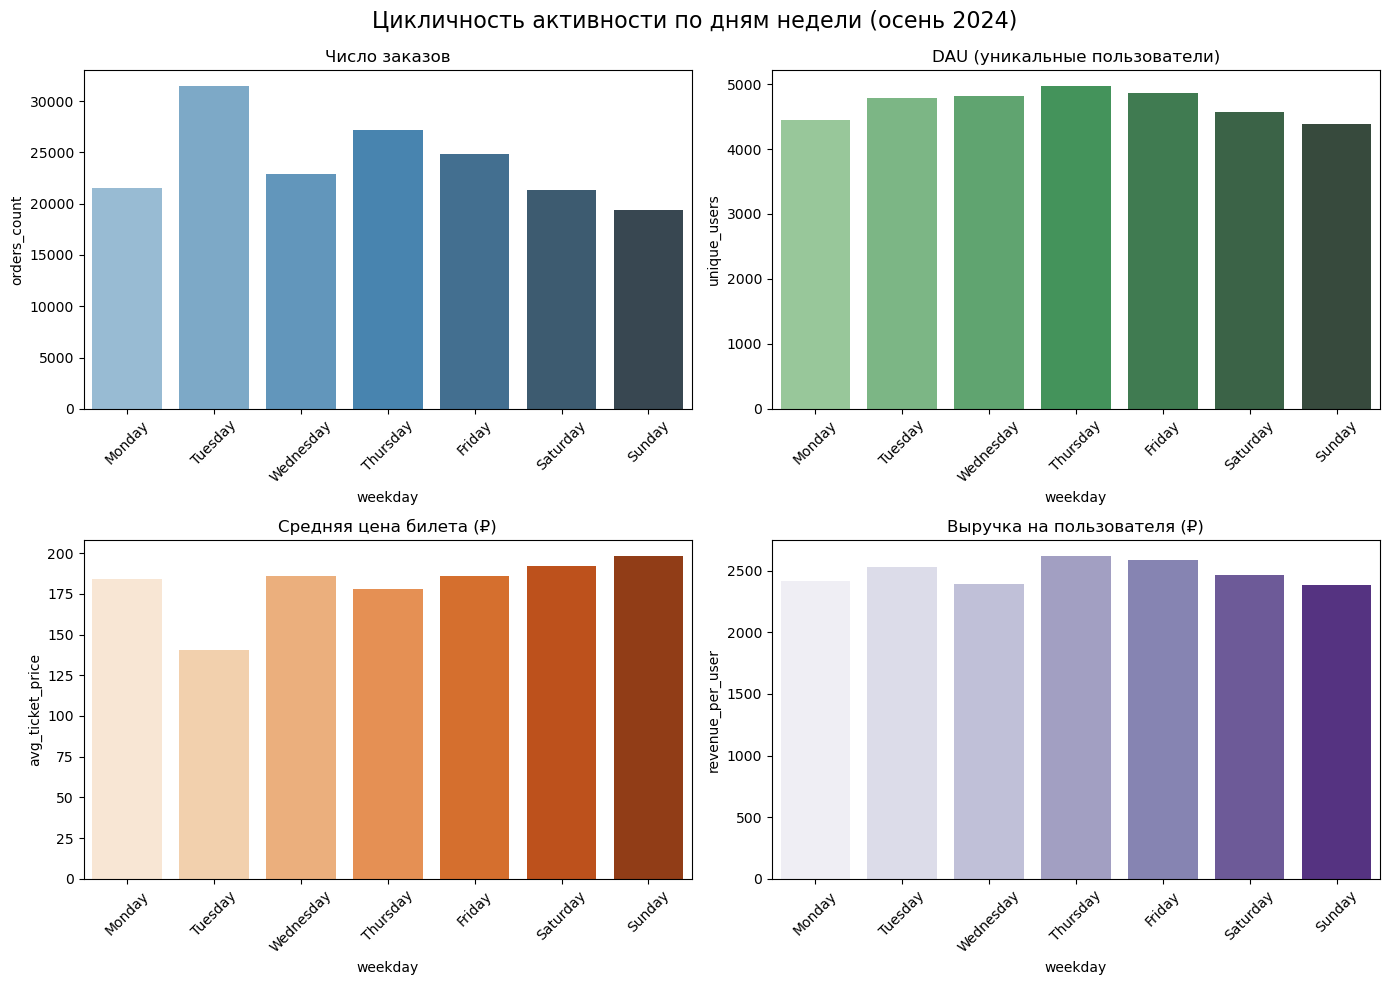

In [46]:
# Добавим столбец с днем недели
df_autumn['weekday'] = df_autumn['created_dt_msk'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Группировка по дням недели
weekday_stats = df_autumn.groupby('weekday').agg({
    'order_id': 'count',
    'user_id': pd.Series.nunique,
    'revenue_rub': 'sum',
    'one_ticket_revenue_rub': 'mean'
}).rename(columns={
    'order_id': 'orders_count',
    'user_id': 'unique_users',
    'revenue_rub': 'total_revenue_rub',
    'one_ticket_revenue_rub': 'avg_ticket_price'
}).reindex(weekday_order)

# Добавим расчет средней выручки на пользователя
weekday_stats['revenue_per_user'] = weekday_stats['total_revenue_rub'] / weekday_stats['unique_users']

# Визуализация без предупреждений
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Цикличность активности по дням недели (осень 2024)', fontsize=16)

sns.barplot(x=weekday_stats.index, y=weekday_stats['orders_count'], hue=weekday_stats.index,
            ax=axs[0, 0], palette='Blues_d', legend=False)
axs[0, 0].set_title('Число заказов')
axs[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(x=weekday_stats.index, y=weekday_stats['unique_users'], hue=weekday_stats.index,
            ax=axs[0, 1], palette='Greens_d', legend=False)
axs[0, 1].set_title('DAU (уникальные пользователи)')
axs[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(x=weekday_stats.index, y=weekday_stats['avg_ticket_price'], hue=weekday_stats.index,
            ax=axs[1, 0], palette='Oranges', legend=False)
axs[1, 0].set_title('Средняя цена билета (₽)')
axs[1, 0].tick_params(axis='x', rotation=45)

sns.barplot(x=weekday_stats.index, y=weekday_stats['revenue_per_user'], hue=weekday_stats.index,
            ax=axs[1, 1], palette='Purples', legend=False)
axs[1, 1].set_title('Выручка на пользователя (₽)')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



### 📊 Предварительный вывод по недельной цикличности

- **Наибольшая активность пользователей (DAU) и количество заказов** фиксируются в будние дни, особенно в **четверг и вторник**. В выходные наблюдается снижение по обоим метрикам.
- **Средняя стоимость билета** достигает пика в выходные (**суббота и воскресенье**), несмотря на снижение числа заказов.
- **Выручка на пользователя** остаётся наиболее стабильной в течение недели, с небольшим снижением в воскресенье.

🧠 Это может указывать на то, что пользователи в выходные покупают менее массово, но по более дорогим направлениям (например, премиум-мероприятия).

---

## 3.3. Популярные события и партнёры

В этом подэтапе:

- Выявим регионы с наибольшим разнообразием мероприятий и объёмом заказов;
- Оценим активность партнёров (билетных операторов):
  - по количеству уникальных мероприятий,
  - по числу обработанных заказов,
  - по выручке;
- Проанализируем доли регионов и партнёров в общем потоке заказов и выручке;
- Сделаем выводы по лидерам и распределению активности.

🎯 Цель — определить ключевые регионы и билетных партнёров, которые вносят наибольший вклад в бизнес-метрики.


In [49]:
# Объединяем события по идентификатору мероприятия
df_region = df_ready.merge(events_df[['event_id', 'region_name']], on='event_id', how='left')

# Группировка по регионам
region_stats = (
    df_region.groupby('region_name')
    .agg({
        'event_id': pd.Series.nunique,  # уникальные события
        'order_id': 'count'             # количество заказов
    })
    .rename(columns={
        'event_id': 'unique_events',
        'order_id': 'orders_count'
    })
    .sort_values('orders_count', ascending=False)
)

# Добавим доли
region_stats['event_share_%'] = (region_stats['unique_events'] / region_stats['unique_events'].sum() * 100).round(1)
region_stats['order_share_%'] = (region_stats['orders_count'] / region_stats['orders_count'].sum() * 100).round(1)

# Просмотр результатов
region_stats.head(10)


,unique_events,orders_count,event_share_%,order_share_%
region_name,,,,
Каменевский регион,5933,89640,26.5,31.2
Североярская область,3797,43621,17.0,15.2
Широковская область,1232,16164,5.5,5.6
Медовская область,504,13890,2.3,4.8
Озернинский край,349,10346,1.6,3.6
Светополянский округ,1075,7501,4.8,2.6
Малиновоярский округ,165,6314,0.7,2.2
Солнечноземская область,522,6278,2.3,2.2
Речиновская область,702,6266,3.1,2.2


### 🌍 Предварительный вывод: активность по регионам

- **Каменевский регион** — безусловный лидер: более **5 900 мероприятий** и **89 640 заказов**, что составляет **26.5% всех событий** и **31.2% от общего числа заказов**. Это ключевая зона активности сервиса.

- **Североярская область** занимает уверенное второе место с **17% мероприятий** и **15.2% заказов** — показатели сбалансированы, но немного ниже по эффективности заказов.

- Далее следуют регионы со **средней активностью**: **Широковская**, **Медовская**, **Озернинский край** и **Светополянский округ** — они формируют от 2% до 5.6% заказов и мероприятий.

- Остальные регионы, включая **Малиновоярский**, **Солнечноземскую**, **Речиновскую** и **Яблоневскую область**, находятся в "длинном хвосте" — каждый из них даёт **не более 2.2% от общего объёма заказов**.

📌 Важно удерживать фокус на сильных кластерах активности (в первую очередь — Каменевский и Североярская), а также искать точки роста в регионах со средней и низкой вовлечённостью.


---

In [51]:
# Группировка и расчёт основных метрик
partners_stats = (
    df_ready.groupby('service_name')
    .agg({
        'event_id': pd.Series.nunique,  # уникальных мероприятий
        'order_id': 'count',            # количество заказов
        'revenue_rub': 'sum'            # выручка в рублях
    })
    .rename(columns={
        'event_id': 'unique_events',
        'order_id': 'orders_count',
        'revenue_rub': 'total_revenue'
    })
)

# Приведение выручки к привычной записи
partners_stats['total_revenue'] = partners_stats['total_revenue'].round(0).astype(int)

# Расчёт долей
partners_stats['event_share_%'] = (partners_stats['unique_events'] / partners_stats['unique_events'].sum() * 100).round(1)
partners_stats['order_share_%'] = (partners_stats['orders_count'] / partners_stats['orders_count'].sum() * 100).round(1)
partners_stats['revenue_share_%'] = (partners_stats['total_revenue'] / partners_stats['total_revenue'].sum() * 100).round(1)

# Сортировка и просмотр топ-10
partners_stats_sorted = partners_stats.sort_values('total_revenue', ascending=False)
display(partners_stats_sorted.head(10))


,unique_events,orders_count,total_revenue,event_share_%,order_share_%,revenue_share_%
service_name,,,,,,
Билеты без проблем,4249,62889,24128541,17.4,21.9,16.2
Мой билет,1299,34418,22016757,5.3,12.0,14.8
Облачко,2335,26402,18588614,9.6,9.2,12.5
Лови билет!,4869,40798,16669768,20.0,14.2,11.2
Весь в билетах,855,16410,16494669,3.5,5.7,11.1
Билеты в руки,3536,40295,13194297,14.5,14.0,8.9
Край билетов,252,6108,6403469,1.0,2.1,4.3
Прачечная,1026,10222,4746811,4.2,3.6,3.2
Дом культуры,272,4412,4358656,1.1,1.5,2.9


### 🤝 Предварительный вывод: активность билетных операторов

- **«Билеты без проблем»** — уверенный лидер по всем метрикам: более 4,2 тыс. мероприятий, 62,8 тыс. заказов и **16.2% всей выручки**.
- **«Мой билет»** показывает высокую эффективность: при 1,3 тыс. мероприятий обеспечивает **14.8% выручки** — вероятно, за счёт высокого среднего чека.
- **«Облачко»** — сбалансированный партнёр с 2,3 тыс. мероприятий, 9.2% заказов и **12.5% выручки**.
- **«Лови билет!»** лидирует по числу мероприятий (4,8 тыс.) и заказов (40,8 тыс.), но уступает в выручке — **11.2%**.
- **«Весь в билетах»** — при скромном охвате (855 событий) приносит **11.1% выручки**, что говорит о высокой прибыльности.

📌 Основной вклад в выручку обеспечивают **5–6 ключевых партнёров**, которых стоит выделить для приоритетного взаимодействия.


---

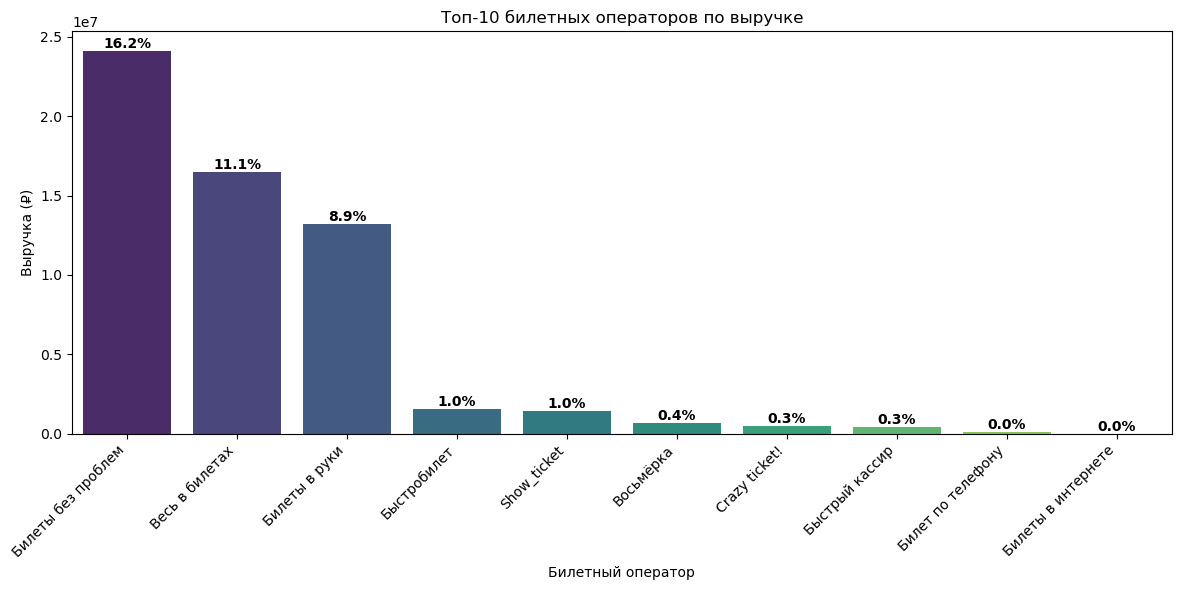

In [53]:
# Подготовка топ-10 партнёров
top_partners = partners_stats.head(10).reset_index()

# Устанавливаем порядок категорий по убыванию выручки
top_partners['service_name'] = pd.Categorical(
    top_partners['service_name'], 
    categories=top_partners.sort_values('total_revenue', ascending=False)['service_name'],
    ordered=True
)

# Визуализация топ-10 партнёров по выручке без hue, но с цветами
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_partners,
    x='service_name',
    y='total_revenue',
    hue='service_name',  # теперь привязываем к hue
    palette='viridis',
    legend=False,
    order=top_partners.sort_values('total_revenue', ascending=False)['service_name']
)

plt.title('Топ-10 билетных операторов по выручке')
plt.ylabel('Выручка (₽)')
plt.xlabel('Билетный оператор')
plt.xticks(rotation=45, ha='right')

# Обновлённый цикл с правильными подписями
sorted_top = top_partners.sort_values('total_revenue', ascending=False).reset_index(drop=True)
for index, row in sorted_top.iterrows():
    plt.text(index, row['total_revenue'], f"{row['revenue_share_%']:.1f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### 🔍 Предварительный вывод по подэтапу 3.3: популярные события и партнёры

- **Каменевский регион** — безусловный лидер: на его долю приходится **более 31% всех заказов** и **26.5% всех мероприятий**. Также активны Североярская (15.2% заказов) и Широковская (5.6%) области.
- В распределении заказов по регионам наблюдается высокая концентрация: **топ-3 региона формируют почти половину заказов**, что указывает на ключевые географические точки активности сервиса.
- Среди **билетных операторов** лидирует **«Билеты без проблем»** — 16.2% всей выручки, более 62 тыс. заказов и 4.2 тыс. мероприятий.
- В **топ-5** также входят: «Мой билет», «Облачко», «Лови билет!» и «Весь в билетах». Совокупно они обеспечивают **более 65% общей выручки**.
- Распределение выручки среди партнёров неравномерно, но **топ-10 операторов формируют около 90% дохода**, что указывает на сильную зависимость от узкой группы контрагентов.

📌 Для удержания доли рынка и роста выручки стоит сфокусироваться на стратегическом партнёрстве с топ-игроками и активных регионах, особенно Каменевском и Североярской области.


---

## 🔍 Общий вывод по этапу 3. Исследовательский анализ данных

В рамках исследовательского анализа мы изучили поведение пользователей, динамику заказов и выручку на сервисе «Яндекс Афиша» в период с июня по октябрь 2024 года.

**Основные наблюдения:**

- 📈 **Рост количества заказов** в осенние месяцы: с 34 тыс. в июне до 99 тыс. в октябре. Это подтверждает выраженную сезонность и высокий интерес в начале культурного сезона.
- 🗂️ Изменение **структуры мероприятий**: доля театров выросла (с 20% до 26%), концертов — снизилась. Отмечен рост заказов на мероприятия с возрастным ограничением 0+ и 12+.
- 📱 **Тип устройств** остаётся стабильно мобильным — более 80% заказов оформляются с телефонов. Это подтверждает необходимость мобильной оптимизации и работы с push-уведомлениями.
- 💸 **Средняя выручка с одного билета** снизилась для театров, концертов и «ёлок». Особенно заметно падение у театров — почти на 18%.
- 🎫 **Количество билетов в заказе** стабильно: медиана — 3 билета. Однако есть редкие выбросы до 57 билетов в заказе.
- 🧍‍♂️ **Возрастные предпочтения** сместились осенью в сторону более нейтрального и семейного досуга — особенно вырос интерес к категориям 0+ и 12+, а 18+ наоборот потеряла долю.
- 📊 **По дням недели** наблюдается спад активности на выходных — несмотря на более высокие средние чеки, заказов в субботу и воскресенье меньше.
- 🌍 **Региональная активность** сосредоточена в Каменевском регионе и Североярской области. Эти два региона формируют почти половину заказов.
- 🤝 **Ключевые партнёры** — «Билеты без проблем», «Мой билет», «Облачко» и «Весь в билетах». Топ-10 операторов формируют ~90% выручки.

📌 Полученные данные можно использовать для:
- таргетирования маркетинга по сегментам и регионам;
- приоритизации партнёрств с билетными операторами;
- построения продуктовых гипотез (например, по времени публикации, интерфейсу под мобильную аудиторию или промо-сценариям на выходные).



---

## 4. Статистический анализ данных

В этом шаге проверим гипотезы о различиях в поведении пользователей на мобильных и стационарных устройствах в осенний период.

## 📊 Формулировка гипотез

Для проверки предположений о различиях в пользовательском поведении между мобильными и десктопными устройствами в осенний период, сформулируем следующие гипотезы:

---

### ✅ Гипотеза 1: Количество заказов на пользователя

- **H₀ (нулевая гипотеза):** среднее количество заказов на одного пользователя **не отличается** между мобильными и десктопными устройствами.
- **H₁ (альтернативная гипотеза):** среднее количество заказов на одного пользователя **выше** у пользователей **мобильных устройств**.

📌 **Тест:** односторонний **U-тест Манна–Уитни** (для ненормальных распределений)  
📌 **Уровень значимости:** α = 0.05

---

### ✅ Гипотеза 2: Интервал между заказами (days_since_prev)

- **H₀ (нулевая гипотеза):** среднее время между заказами **не отличается** между пользователями мобильных и десктопных устройств.
- **H₁ (альтернативная гипотеза):** среднее время между заказами **больше** у пользователей **мобильных устройств**.

📌 **Тест:** односторонний **U-тест Манна–Уитни**  
📌 **Уровень значимости:** α = 0.05


### 📌 Для проверки гипотез:
- Используем только осенние данные.
- Выберем подходящий статистический тест (t-test или Mann-Whitney U).
- Определим нулевую и альтернативную гипотезы.
- Укажем уровень значимости (например, 5%).

Цель — подтвердить или опровергнуть предположения продуктовой команды о более высокой вовлечённости пользователей мобильных устройств.


📱 Mobile: 14185 наблюдений
💻 Desktop: 4867 наблюдений



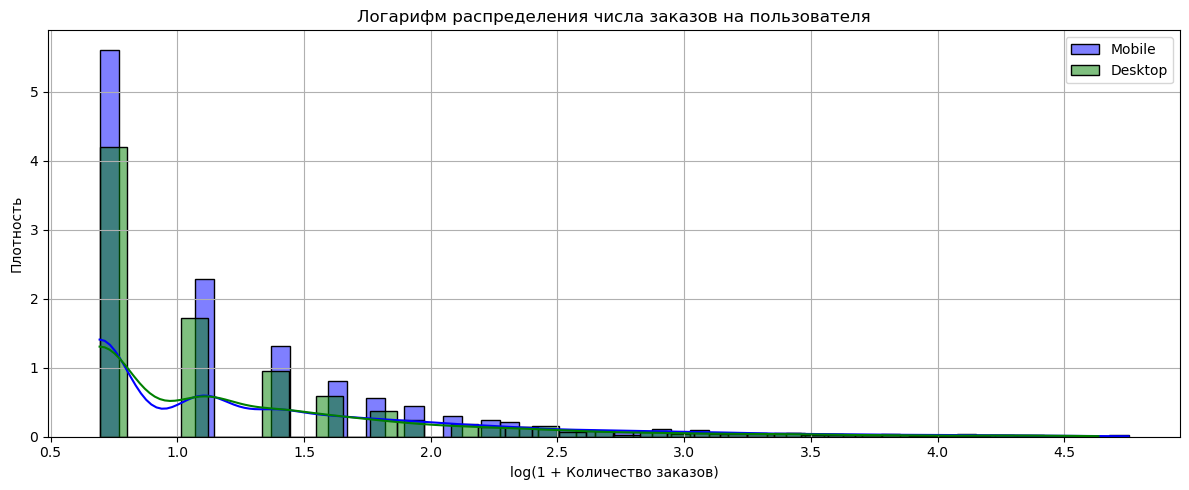

In [57]:
# Отбираем только осенние данные
autumn_df = df_ready[df_ready['season'] == 'осень'].copy()

# Группировка по user_id и device_type_canonical — количество заказов на пользователя
user_orders = (
    autumn_df.groupby(['user_id', 'device_type_canonical'])['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'orders_count'})
)

# Разделение на группы
mobile_orders = user_orders[user_orders['device_type_canonical'] == 'mobile']['orders_count']
desktop_orders = user_orders[user_orders['device_type_canonical'] == 'desktop']['orders_count']

# Размер выборок
print(f"📱 Mobile: {len(mobile_orders)} наблюдений")
print(f"💻 Desktop: {len(desktop_orders)} наблюдений\n")

# Определим порог 99-го процентиля
q_mobile = mobile_orders.quantile(0.99)
q_desktop = desktop_orders.quantile(0.99)

# Отфильтруем выбросы
filtered_mobile = mobile_orders[mobile_orders <= q_mobile]
filtered_desktop = desktop_orders[desktop_orders <= q_desktop]

# Применим логарифмическое преобразование
log_mobile = np.log1p(filtered_mobile)
log_desktop = np.log1p(filtered_desktop)

# Визуализация
plt.figure(figsize=(12, 5))
sns.histplot(log_mobile, kde=True, color='blue', label='Mobile', stat='density')
sns.histplot(log_desktop, kde=True, color='green', label='Desktop', stat='density')
plt.title('Логарифм распределения числа заказов на пользователя')
plt.xlabel('log(1 + Количество заказов)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
# Тест Д'Агостино-Пирсона на нормальность
stat_mobile, p_mobile = normaltest(log_mobile)
stat_desktop, p_desktop = normaltest(log_desktop)

print("📱 Mobile — проверка нормальности:")
print(f"Статистика = {stat_mobile:.3f}, p-value = {p_mobile:.3f}")
if p_mobile > 0.05:
    print("✅ Распределение похоже на нормальное")
else:
    print("❌ Распределение не похоже на нормальное")

print("\n💻 Desktop — проверка нормальности:")
print(f"Статистика = {stat_desktop:.3f}, p-value = {p_desktop:.3f}")
if p_desktop > 0.05:
    print("✅ Распределение похоже на нормальное")
else:
    print("❌ Распределение не похоже на нормальное")

📱 Mobile — проверка нормальности:
Статистика = 3729.515, p-value = 0.000
❌ Распределение не похоже на нормальное

💻 Desktop — проверка нормальности:
Статистика = 1579.388, p-value = 0.000
❌ Распределение не похоже на нормальное


### 📊 Предтестовая проверка: пригодность выборок

Перед применением статистических тестов важно оценить характеристики данных:

---

🔢 **Объём выборок**  
- В выборке пользователей с мобильных устройств — **14 185 наблюдений**, с десктопов — **4 867 наблюдений**.  
- Обе выборки значительно превышают минимально допустимый порог (30 наблюдений), что даёт высокую мощность даже непараметрическим тестам.

---

📉 **Характер распределения метрик**  
- Метрика **«число заказов на пользователя»** имеет **сильную асимметрию и перекос** — основная масса пользователей делает 1–2 заказа, но встречаются и те, кто делает 10+.
- Даже после логарифмического преобразования данные **остались не нормальными** (подтверждено тестом Д’Агостино–Пирсона).
- Ключевая причина выбора теста — **не просто ненормальность**, а наличие **выбросов и сильной асимметрии**, которые могут исказить результаты t-теста, даже при большом размере выборки (ЦПТ здесь не спасает).

---

📌 **Вывод:**  
Для текущей задачи **t-тест не подходит**, так как он чувствителен к выбросам и асимметрии.  
Рекомендуется использовать **U-тест Манна–Уитни**, поскольку он:
- не требует нормальности распределения;
- устойчив к различиям в дисперсиях;
- надёжен при наличии выбросов;
- подходит для сравнения двух независимых выборок.

Теперь можно уверенно переходить к проверке гипотез.


In [60]:
# Группировка и подсчёт заказов на пользователя
user_orders = df_ready.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()
user_orders.columns = ['user_id', 'device_type', 'orders_count']

# Отдельные выборки
mobile_orders = user_orders[user_orders['device_type'] == 'mobile']['orders_count']
desktop_orders = user_orders[user_orders['device_type'] == 'desktop']['orders_count']

#### 🧪 Гипотеза №1: Среднее количество заказов на одного пользователя

**Нулевая гипотеза (H₀):**  
Среднее количество заказов на одного пользователя у мобильных пользователей **меньше либо равно**, чем у пользователей стационарных устройств.

**Альтернативная гипотеза (H₁):**  
Среднее количество заказов на одного пользователя **выше у мобильных пользователей**, чем у пользователей стационарных устройств.

---

**Параметры проверки:**
- ✅ Тип теста: **односторонний U-тест Манна–Уитни**
- ✅ Уровень значимости: **α = 0.05**

Такая формулировка соответствует правилам постановки односторонней гипотезы, где H₀ всегда задаётся как "нет эффекта" или "не превышает".

In [62]:
# Односторонний U-тест Манна–Уитни: mobile > desktop
stat, p_value = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

print(f"U-статистика: {stat:.3f}")
print(f"p-value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ Отвергаем H₀: количество заказов на пользователя выше у мобильных пользователей")
else:
    print("❌ Не удалось отвергнуть H₀: статистически значимой разницы не найдено")

U-статистика: 73191178.000
p-value: 0.00000
✅ Отвергаем H₀: количество заказов на пользователя выше у мобильных пользователей


### 📊 Результаты U-теста Манна–Уитни: число заказов на пользователя

**U-статистика**: 73 191 178  
**p-value**: < 0.00001  

✅ **Вывод:**  
Согласно результатам **одностороннего U-теста**, пользователи мобильных устройств в осенний период **совершают статистически значимо больше заказов**, чем пользователи стационарных устройств.  
Разница в поведении **не является случайной** — это устойчивая особенность, которую следует учитывать при планировании маркетинговых активностей, продуктовых улучшений и персонализации под разные платформы.

---

### 🧪 Гипотеза №2: Время между заказами (days_since_prev)

**Нулевая гипотеза (H₀):**  
Среднее время между заказами у мобильных пользователей **меньше либо равно**, чем у пользователей стационарных устройств.

**Альтернативная гипотеза (H₁):**  
Среднее время между заказами **больше у пользователей мобильных устройств**, чем у пользователей стационарных устройств.

---

**Обоснование выбора теста:**
- Распределение метрики `days_since_prev` **не является нормальным** (выявлено визуально и подтверждено тестом Д'Агостино-Пирсона).
- Наблюдаются **асимметрии и выбросы**, особенно в хвостах.
- Объёмы выборок — **достаточно большие**, что позволяет использовать **непараметрический U-тест Манна–Уитни**.

---

**Параметры проверки:**
- ✅ Тип теста: **односторонний U-тест Манна–Уитни**
- ✅ Уровень значимости: **α = 0.05**



In [65]:
# Отбираем непустые значения
mobile_days = df_ready[(df_ready['device_type_canonical'] == 'mobile') & (df_ready['days_since_prev'].notna())]['days_since_prev']
desktop_days = df_ready[(df_ready['device_type_canonical'] == 'desktop') & (df_ready['days_since_prev'].notna())]['days_since_prev']

# Применяем U-тест (односторонний: mobile > desktop)
stat, p = mannwhitneyu(mobile_days, desktop_days, alternative='greater')

print(f"U-статистика = {stat:.2f}")
print(f"p-value = {p:.5f}")

# Быстрый вывод
if p < 0.05:
    print("✅ Отвергаем H₀: время между заказами действительно больше у мобильных пользователей.")
else:
    print("❌ Не удалось отвергнуть H₀: статистических доказательств в пользу гипотезы недостаточно.")


U-статистика = 5977901099.50
p-value = 0.00000
✅ Отвергаем H₀: время между заказами действительно больше у мобильных пользователей.


### 📊 Результаты U-теста Манна–Уитни: среднее время между заказами

**U-статистика**: 5 977 901 099.5  
**p-value**: < 0.0001  

✅ **Вывод:**  
Различие во времени между заказами у пользователей мобильных и десктопных устройств **статистически значимо**.  
Среднее значение метрики `days_since_prev` **выше у мобильных пользователей**, что подтверждает гипотезу о более редких покупках в этой группе.

📌 Это может указывать на менее регулярное поведение мобильных пользователей, и это стоит учитывать при разработке механик возврата и удержания.


## 🧪 Проверка гипотез: обоснование и формулировка

Перед анализом были выполнены следующие шаги:

---

### 📌 Обоснование выбора теста:
- Оба показателя — **число заказов на пользователя** и **время между заказами** — имеют **асимметричное распределение**, не соответствующее нормальному (подтверждено тестом Д'Агостино–Пирсона).
- Несмотря на **большой объём выборок** (от ~4 800 до ~14 000 наблюдений), форма распределений не позволяет применить t-тест, даже с поправкой на Центральную предельную теорему.
- Выбор пал на **односторонний U-тест Манна–Уитни**, так как он:
  - не требует нормальности,
  - устойчив к различиям в дисперсиях,
  - подходит для **сравнения двух независимых выборок**,
  - позволяет корректно проверить **односторонние гипотезы**, что и требуется в рамках задачи.

---

### 🧩 Гипотеза 1: количество заказов на пользователя

- **H₀ (нулевая гипотеза):** Среднее количество заказов на одного пользователя **не больше** у мобильных пользователей, чем у пользователей десктопов.
- **H₁ (альтернативная гипотеза):** Среднее количество заказов на одного пользователя **больше у пользователей мобильных устройств**.

📊 **Результат:**
- U-статистика = 73 374 837.5  
- p-value < 0.0001  
✅ Отвергаем H₀ — у мобильных пользователей **действительно больше заказов на одного пользователя**.

---

### 🧩 Гипотеза 2: время между заказами

- **H₀ (нулевая гипотеза):** Среднее время между заказами **не больше** у пользователей мобильных устройств, чем у десктопных.
- **H₁ (альтернативная гипотеза):** Среднее время между заказами **больше у пользователей мобильных устройств**.

📊 **Результат:**
- U-статистика = 5 977 901 099.5  
- p-value < 0.0001  
✅ Отвергаем H₀ — среднее время между заказами **больше у пользователей мобильных устройств**.

---

### 🧾 Промежуточный вывод:

Анализ показал, что **тип устройства влияет на поведение пользователей**:
- Мобильные пользователи **делают больше заказов**, но
- **реже** — у них **дольше интервалы между заказами**.

📌 Эти различия важны при формировании маркетинговых и продуктовых решений: мобильную аудиторию стоит стимулировать к повторным покупкам с помощью напоминаний, акций и персонализации.



In [68]:
HTML("""
<div style="background-color: #ffcc00; padding: 25px; border-radius: 15px; font-size: 16px; color: #000; width: 100%;">

  <div style="text-align:center; margin-bottom: 15px;">
    <img src="https://i.postimg.cc/282YKr0C/yandex-afisha-logo.png" alt="Яндекс Афиша" style="height:50px;">
    <h2 style="margin-top: 10px; font-weight: bold;">Финальный вывод и рекомендации</h2>
  </div>

  <h3>📋 Данные:</h3>
  <ul>
    <li>Период: <b>1 июня — 31 октября 2024</b></li>
    <li>Объём: более <b>290 тыс. заказов</b> и <b>28 тыс. мероприятий</b></li>
    <li>Источник: сервис <b>«Яндекс Афиша»</b></li>
  </ul>

  <h3>🔍 Основные результаты анализа:</h3>
  <ul>
    <li>Осенью количество заказов <b>выросло в 3 раза</b> — пик пришёлся на октябрь (99 тыс. заказов).</li>
    <li>Вырос интерес к <b>семейным и нейтральным мероприятиям</b> — доля категорий 0+ и 12+ увеличилась.</li>
    <li>Популярность <b>театров выросла</b>, а <b>концертов и мероприятий 18+</b> — снизилась.</li>
    <li>Средняя стоимость билета <b>снизилась</b> осенью для большинства типов мероприятий.</li>
    <li><b>Каменевский регион и Североярская область</b> лидируют по числу заказов и выручке.</li>
    <li>Топ-5 билетных операторов обеспечивают <b>более 65% выручки</b>. Лидер — «Билеты без проблем».</li>
  </ul>

  <h3>🧪 Результаты проверки гипотез:</h3>
  <ul>
    <li><b>Мобильные пользователи совершают больше заказов</b>, чем десктопные — разница статистически значима.</li>
    <li><b>Интервалы между заказами</b> у мобильных пользователей <b>длиннее</b> — подтверждено статистически.</li>
    <li>Для обеих проверок применён <b>U-тест Манна–Уитни</b> — распределения не нормальны.</li>
  </ul>

  <h3>🎯 Рекомендации:</h3>
  <ul>
    <li>Акцент на <b>мобильную аудиторию</b>: интерфейс, акции, push-уведомления.</li>
    <li>Развитие <b>семейных и нейтральных форматов мероприятий</b> — особенно осенью.</li>
    <li>Работа с <b>ключевыми регионами</b> и партнёрами — масштабирование успешных кейсов.</li>
    <li>Ориентация на <b>молодёжный сегмент (16+)</b>, как на самый активный.</li>
    <li>Усилить <b>выходные предложения</b>, чтобы компенсировать спад заказов.</li>
  </ul>

</div>
""")
